In [81]:
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

# Markov Decision Processes
A [Markov Decision Process](https://en.wikipedia.org/wiki/Markov_decision_process) is formally a 5-tuple $(S, A, P, R, \gamma)$. In the following, we denote $s_t$ as the state at time $t$, $a_t$ the action taken at time $t$.
* $S$: the state space

* $A$: the action space, or set of actions you are allowed to take

* $P$: a probability distribution over $S \times S \times A$
$$P(s, s', a) = Prob(s_{t+1} = s' | s_t = s, a_t = a)$$

* $R$: the reward function. Formally you can think of $R$ as a function from $S \times A$ to the reals.
$$R(s_t, a_t) = \text{the reward you get from taking action $a_t$ at state $s_t$}$$

* $\gamma$: the discount factor which tells you how much to weigh future rewards versus present rewards. For now, we'll ignore this.


Whenever you have a problem that can be formalized as an MDP you are generally interested in finding a **policy** that will maximize your long term reward. We will formalize this later on, but here are some examples of things that can be formalized as MDPS:
* chess: The reward in these can be modeled as 0 if the game has not yet terminated, -1 if your action leads to you losing the game in your opponents next move, +1 if your action leads to a win in the next move. Note that you can also use a different reward function here, where your reward is equal to the point value of the piece you just captured (0 if no capture), but this can lead to myopic policies that are good at taking pieces while losing you the game.

* breakout: Here the state space is the configuration of bricks present. The action space is just [move paddle left, move paddle right]. The reward function might be the number of bricks broken or the number of game frames that the ball spends aloft.


From these two basic examples of MDP's, we can see that we'll often have a predetermined state /action space and a fixed transition probability function(well in chess, the transition depends on your opponent). The reward function, however, is something that you can play around with. In the next section we'll see an example the Cartpole problem which is a classic control task that can be modeled as an MDP and thus solved with **reinforcement learning** techniques.

# The Cart Pole Environment
In the Cartpole problem we have a pole that is attached to a cart. The goal is to keep the pole balanced for as long as possible. Given some initial unbalanced configuration of pole on the cart, you'll have to move the cart to the left or to the right to keep the pole from falling over.

In [18]:
env = gym.make('CartPole-v0')
env.reset()
rgb = env.render(mode='rgb_array')
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


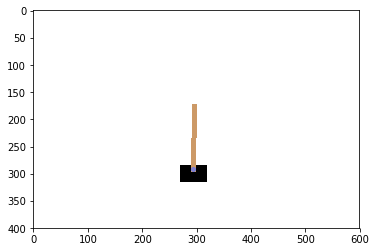

In [25]:
plt.imshow(rgb)

## Cartpole State/Action Space/Reward
The cartpole states are parameterized by 4 real numbers. I think two of them correspond to angles and the other two correspond to something like distance from origin? But I'm not entirely sure.

In [24]:
print("State(aka observation) space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

State(aka observation) space: Box(4,)
Action space: Discrete(2)


Box is a class defined in gym.spaces.box. It is generally used  to represents a vector in $R_n$. In the Cartpole environment, the observation(or state) space is just $R^4$.

The action space is just $\{0, 1 \}$. This corresponds to moving the cart left or right.

The reward is +1 if the pole is still up after taking the given action and 0 if the pole falls over.

## "Winning" the Cartpole Environment
We say that the cartpole problem is "solved" when we have found a policy that can keep the pole up for more than 195 timesteps. This is admittedly fairly arbitrary, but for our purposes, it's good enough.'

# A Linear Decision Model
This problem of keeping the pole up can be reduced to a pseudo-supervised classification problem. The most naive thing we can try to do is to make a linear decision function of the flavor:
$$
f_{w, b}(x)= 
\begin{cases}
    0,& w^T s_t + b \geq 0\\
    1,              & \text{otherwise}
\end{cases}$$
where $x \in \mathbb{R}^4$ is your state vector , $w \in \mathbb{R}^4, b \in \mathbb{R}$. The problem with this is that this doesn't quite fit in the classic supervised learning framework. There is no "ground truth" label to predict here.

# Cross Entropy
We can still get a notion of "good" values for $w$ and $b$ based on how good this decision function $f_{w, b}$ is in practice. So use $f_{w, b}$ to determine which action to take at each time step and then look the total reward that this policy produces(ie: how long does a pole stay upright if we use this function to determine whether to move left or right at each time step). This notion of "quality" can then guide us in what $w$ and $b$ to use.

The [Cross Entropy Method](https://en.wikipedia.org/wiki/Cross-entropy_method) broadly be seen as a sort of evolutionary method for optimization. We want to find a weight vector $w \in \mathbb{R}^4$, bias term $b \in \mathbb{R}$ so that the decision function $f_{w, b}$ can lead to high long term rewards. Broadly speaking, the CEM consists of repeating the following three steps:
a) generating a random sample of candidate variables(in our case it will be the $w$ and $b$s) according to some distribution
b) evaluating each sample's "fitness"(total reward)
c) keeping the top K candidate variables with highest "fitness" and update the sampling procedure with these top K values to get a better performing sample in the next iteration.

We'll model $w$ and $b$ as random variables drawn from a normal distribution with unknown mean $\mu$ and variance $\sigma^2$. Note that we can think of the $[w, b]$ as a vector in $\mathbb{R}^5$. So to save on typing, I'll refer to
the combination of $w$ and $b$ being drawn from a 5-dimensional multivariate normal distribution.

The process for learning these $w$ and $b$ values is as follows:
1. Start with $\mu = [0,0,0, 0, 0]$, $\sigma=1$. This initialization is a bit arbitrary. You can use a different initialization if you'd like.
2. generate random batch of say 50 $w$ and $b$ values according to $\mathcal{N}(\mu, \sigma^2)$
3. For each sample of $w$ and $b$, run the policy that function $f_{w, b}$ induces. Keep track of the reward each function produced.
4. Keep the top ten or so $w, b$ values (as defined by the total reward that their corresponding $f_{w, b}$ functions attained)
5. Update $\mu$ and $\sigma$ with the mean and standard dev of the top 10 $w$ and $b$ values found in the previous step
6. Go back to step 2.

This process is repeated until the $w$ and $b$ values that are sampled produce a good enough policy. 

In [70]:
def get_action(observation, weights):
    '''
    observation: length 4 array
    weights: length 5 array(bias term is included here)
    This computes the f_{w, b} decision function described above
    '''
    w = weights[:-1]
    b = weights[-1]
    if w.dot(observation) + b > 0:
        return 1
    else:
        return 0

In [71]:
def run(env, weight, max_steps):
    '''
    This function uses the given weight(aka w and b in the writeup above)
    as the policy for determining actions
    env: gym environment
    weight: 5-dim numpy array
    max_steps: maximum number of time steps to run the environment for
    '''
    obs = env.reset()
    total_reward = 0
    for i in range(max_steps):
        action = get_action(obs, weight)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    num_steps = i
    
    return total_reward

In [80]:
env.reset()

# w will 
max_rollouts = 100
batch_size = 50
reward_history = []
weight_mean = np.random.normal(0, 1, size=5)
weight_std = 1
max_steps = 300

for e in range(max_rollouts):
    # sampling form N(mu, sigma^2) is the same as sampling from mu + sigma * N(0, 1)
    w_samples = np.ones((batch_size, 1)) * weight_mean + \
                weight_std * np.random.normal(0, 1, (batch_size, 5))
        
    # This gives us a list of tuples of (total reward generated, weight vector)
    rollout_results = [(run(env, w, max_steps), w) for w in w_samples]
    
    # sort the results based on the total reward
    sorted_results = sorted(rollout_results, key=lambda x: x[0], reverse=True)

    # unzip the list of tuples
    steps, weights = [list(i) for i in zip(*sorted_results)]
    
    # update the mean/std of the normal distribution
    weight_mean = np.mean(weights[:10], axis=0)
    weight_std = np.std(weights[:10], axis=0)
    reward_history.extend(steps)
    
    print("Batch {} (episodes {}-{}) | Batch avg: {:.2f} | Running avg {:.2f}".format(e, e * batch_size, (e+1) * batch_size, np.mean(steps), np.mean(reward_history)))
    if np.mean(reward_history[-50:]) > 195:
        print("Done! Last 50 steps have an average total reward of {:.2f}".format(np.mean(reward_history[-50:])))
        break

Batch 0 (episodes 0-50) | Batch avg: 24.40 | Running avg 24.40
Batch 1 (episodes 50-100) | Batch avg: 49.54 | Running avg 36.97
Batch 2 (episodes 100-150) | Batch avg: 68.62 | Running avg 47.52
Batch 3 (episodes 150-200) | Batch avg: 90.30 | Running avg 58.22
Batch 4 (episodes 200-250) | Batch avg: 120.64 | Running avg 70.70
Batch 5 (episodes 250-300) | Batch avg: 143.74 | Running avg 82.87
Batch 6 (episodes 300-350) | Batch avg: 176.88 | Running avg 96.30
Batch 7 (episodes 350-400) | Batch avg: 170.56 | Running avg 105.58
Batch 8 (episodes 400-450) | Batch avg: 181.04 | Running avg 113.97
Batch 9 (episodes 450-500) | Batch avg: 189.72 | Running avg 121.54
Batch 10 (episodes 500-550) | Batch avg: 188.58 | Running avg 127.64
Batch 11 (episodes 550-600) | Batch avg: 198.20 | Running avg 133.52
Done! Last 50 steps have an average total reward of 198.20
